Human Breast Cancer 单切片实验


In [1]:
import random
import numpy as np
import torch
import scanpy as sc
import argparse
import yaml
from yaml import SafeLoader
from package.data_processing import Load10xAdata
import warnings
from package.model import STAMGC
from package.utils import read_json, knn_adj_matrix

warnings.filterwarnings('ignore')
import os
os.chdir('/home/lsfcj/lsf/第一个工作3.0')

In [2]:
file_fold='/data/lsfcj/DATA'

args = argparse.Namespace(
    dataset='HBC',
    slice='Human_Breast_Cancer',
    batch_size=1,
    platform='10x',
    spot_size=0,
    config='./train_config.yaml',
    label=True,
)
config = yaml.load(open(args.config), Loader=SafeLoader)[str(args.slice)]

slice_path = os.path.join(file_fold, args.slice)


torch.manual_seed(config['seed'])
np.random.seed(config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(config['seed'])
    torch.cuda.manual_seed_all(config['seed'])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
random.seed(12345)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8' 
torch.use_deterministic_algorithms(True)

In [4]:
# adata = Load10xAdata(path=slice_path,dataset=args.dataset,slice=args.slice,config=config,args=args).run()
# print(adata)

In [5]:
adata=sc.read_h5ad('./results/'+args.dataset+'/'+args.slice+'/data_processing.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 3798 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'd', 'hvg', 'log1p', 'smooth_r', 'spatial'
    obsm: 'gene_feat', 'graph_neigh', 'graph_neigh_coor', 'negative_mask', 'smooth_gene', 'spatial'


=== Generate pseudo labels! ===


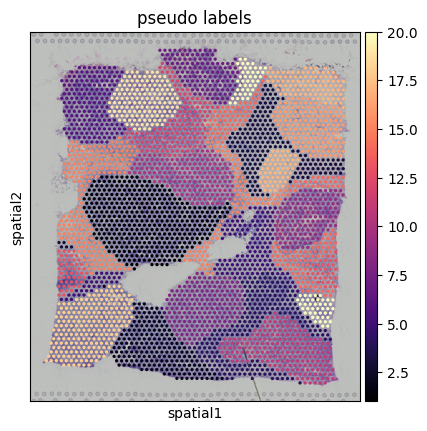

=== train ===
epoch: 0  total_loss: 7.412104606628418  alpha: 1  beta: 0.85  gama: 0.15
epoch: 1  total_loss: 7.395190238952637  alpha: 1  beta: 0.85  gama: 0.15
epoch: 2  total_loss: 7.328684329986572  alpha: 1  beta: 0.85  gama: 0.15
epoch: 3  total_loss: 7.228593826293945  alpha: 1  beta: 0.85  gama: 0.15
epoch: 4  total_loss: 7.135766506195068  alpha: 1  beta: 0.85  gama: 0.15
epoch: 5  total_loss: 7.044186115264893  alpha: 1  beta: 0.85  gama: 0.15
epoch: 6  total_loss: 6.961454391479492  alpha: 1  beta: 0.85  gama: 0.15
epoch: 7  total_loss: 6.878543376922607  alpha: 1  beta: 0.85  gama: 0.15
epoch: 8  total_loss: 6.803940296173096  alpha: 1  beta: 0.85  gama: 0.15
epoch: 9  total_loss: 6.736685276031494  alpha: 1  beta: 0.85  gama: 0.15
epoch: 10  total_loss: 6.673068523406982  alpha: 1  beta: 0.85  gama: 0.15
epoch: 11  total_loss: 6.614667892456055  alpha: 1  beta: 0.85  gama: 0.15
epoch: 12  total_loss: 6.560329437255859  alpha: 1  beta: 0.85  gama: 0.15
epoch: 13  total_loss

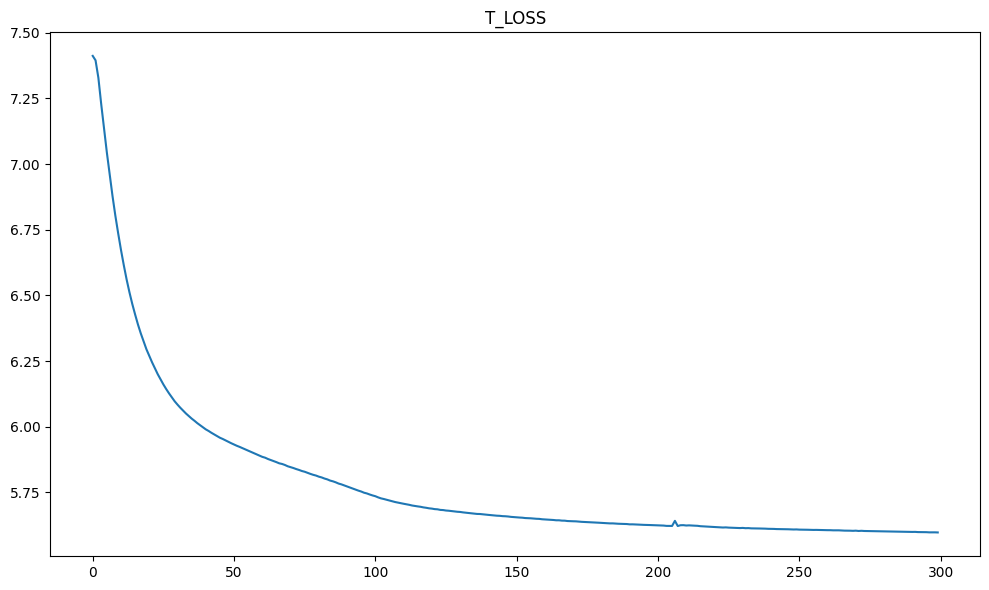

=== load ===
embedding generated, go clustering
calculate metric ARI
ARI: 0.6510689362078919
NMI: 0.7145062790339815


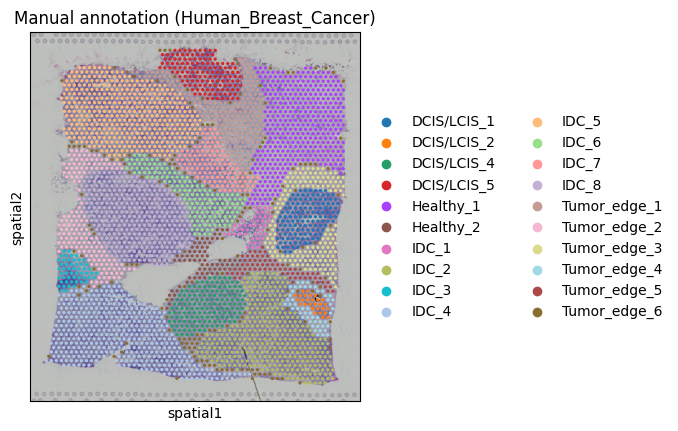

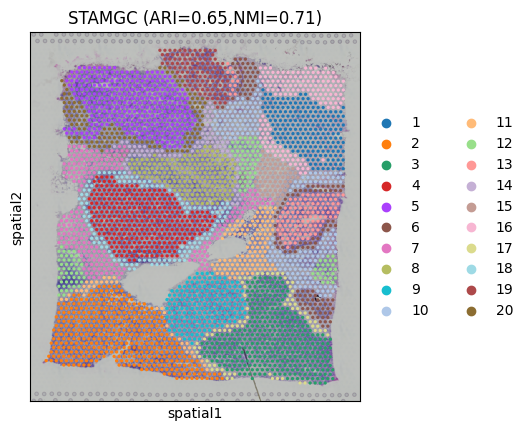

complete!


In [6]:
model=STAMGC(adata,config,args)
adata=model.run()

In [3]:
adata=sc.read_h5ad('./results/'+args.dataset+'/'+args.slice+'/STAMGC.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 3798 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'pseudo_labels', 'domain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'ari', 'd', 'domain_colors', 'ground_truth_colors', 'hvg', 'log1p', 'nmi', 'smooth_r', 'spatial'
    obsm: 'emb_pca', 'gene_feat', 'graph_neigh', 'graph_neigh_coor', 'h', 'mlp', 'negative_mask', 'smooth_gene', 'spatial', 'z'


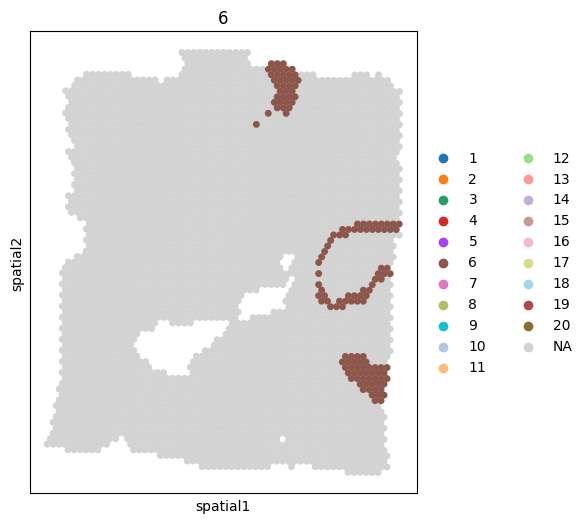

In [4]:
adata.obs['domain']=adata.obs['domain'].astype('category')
adata.obs['6']=adata.obs['domain'][adata.obs['domain']==6]
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (5, 6)
adata.obsm['spatial'][:,1]=-1*adata.obsm['spatial'][:,1]
sc.pl.embedding(adata,basis='spatial',size=100,color='6',show=False)
plt.savefig('./results/'+args.dataset+'/'+args.slice+'/6.png', bbox_inches='tight',dpi=600)
plt.show()

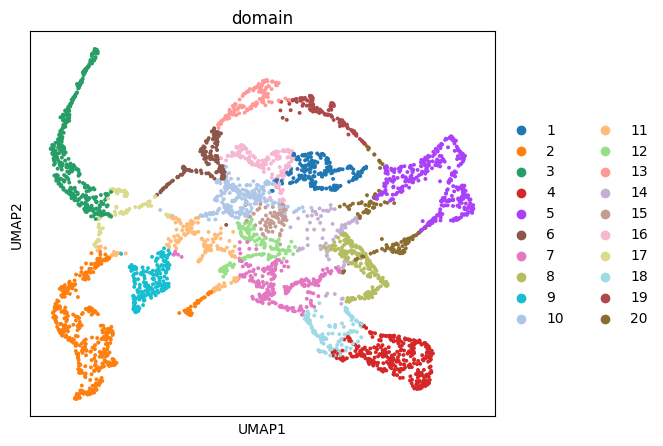

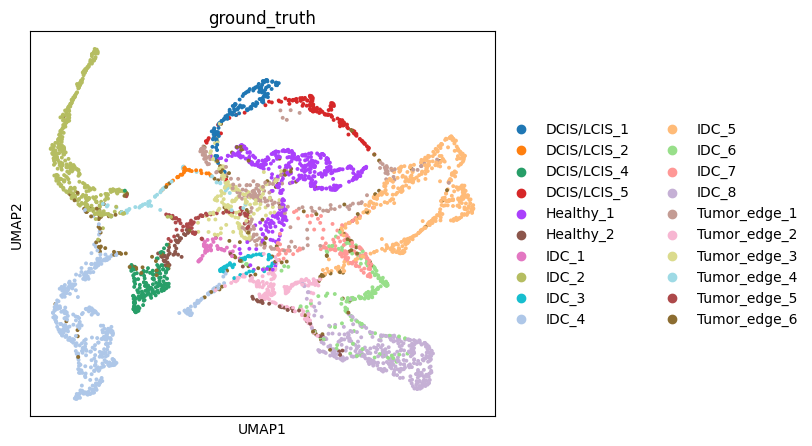

In [9]:
from matplotlib import pyplot as plt
color=['domain','ground_truth']
sc.pp.neighbors(adata, use_rep='z', metric='cosine')
sc.tl.umap(adata)
for i in color:
    fig, ax = plt.subplots(figsize=(6, 5))
    sc.pl.umap(adata, color=i,ax=ax, show=False)
    plt.savefig('./results/'+args.dataset+'/'+args.slice+'/'+i+'_umap.png')
    plt.show()
    plt.close(fig)

正在进行差异表达分析: 6 vs 其他聚类...


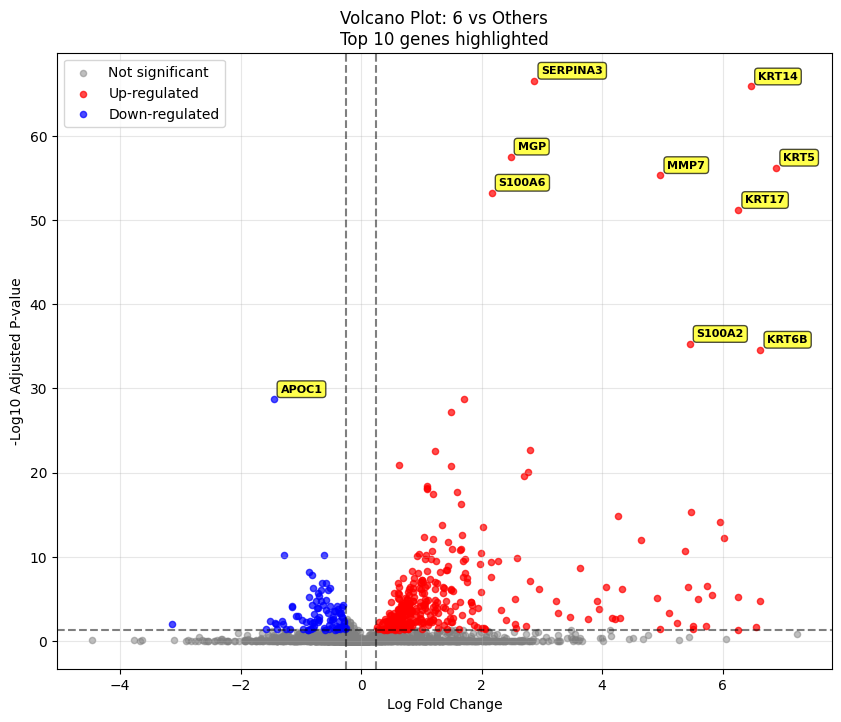

In [5]:
from package.utils import volcano_plot
adata.obs['domain']=adata.obs['domain'].astype('str')
top_genes,result=volcano_plot(adata,target_cluster='6',cluster_key='domain',xlim=(-10,10),save_path='./results/HBC/Human_Breast_Cancer/vocano_6.png')

In [ ]:
'ACPP', 'KLK3', 'MSMB', 'KLK2', 'NEFH', 'AZGP1', 'RDH11', 'NKX3-1', 'TMPRSS2', 'PLA2G2A', 'TACSTD2', 'NPY', 'CLDN4', 'STEAP2', 'TSPAN1', 'SLC45A3', 'GOLM1', 'DHCR24', 'DSP', 'FOLH1', 'SLC44A4', 'MME', 'FXYD3', 'GDF15', 'HOXB13', 'RAB3B', 'DHRS7', 'KLK4', 'CKB', 'PTPRF', 'KIAA1244', 'CPE', 'PMEPA1', 'AGR2', 'PPAP2A', 'CDH1', 'SLC30A4', 'KRT18', 'SEC11C', 'DPP4', 'KIAA1324', 'PDLIM5', 'ARG2', 'EHF', 'SLC39A6', 'ELF3', 'FOXA1', 'SPDEF', 'NEDD4L', 'NIPAL3', 'MLPH', 'CREB3L4', 'TPD52', 'CLDN3', 'STEAP4', 'DCXR', 'SPOCK1', 'SORD', 'EPCAM', 'ALDH1A3', 'DSG2', 'NDRG1', 'HOMER2', 'ENTPD5', 'H2AFJ', 'CYB561', 'NUPR1', 'ABCC4', 'C1orf116', 'TBX3', 'SPINT2', 'IDH1', 'PPAPDC1B', 'PERP', 'KRT8', 'BMPR1B', 'P4HB', 'TSPAN8', 'SLC12A2', 'PPP3CA', 'H1F0', 'PGM3', 'BCAS1', 'KIF5C', 'SLC2A12', 'CANT1', 'PART1', 'ERBB3', 'RBM47', 'TMEM141', 'HIST1H2AC', 'ADI1', 'STEAP1', 'MPC2', 'CD9', 'FLNB', 'GRHL2', 'LRIG1', 'ZG16B', 'HDLBP', 'TMC5', 'FAM213A', 'SFN', 'TMEM79', 'MAP7', 'HN1L', 'TSTD1', 'TCEA3', 'RASEF', 'APLP2', 'ESRP1', 'ANXA3', 'PRSS8', 'HLA-B', 'IFI16', 'WIPF1', 'TMSB10', 'HLA-E', 'ZEB2', 'HCLS1', 'LCP2', 'CD93', 'CD53', 'SLA', 'MSN', 'TAGAP', 'ARHGDIB', 'BTG1', 'TNFRSF1B', 'SAMHD1', 'FGL2', 'ITGB2', 'TYROBP', 'FYB', 'TMSB4X', 'CYBB', 'SLC2A3', 'CTSS', 'HLA-DRB5', 'GPR183', 'LAPTM5', 'HLA-DQA1', 'NR4A2', 'RGS2', 'CXCR4', 'TNFAIP3', 'VIM', 'PTPRC', 'A2M', 'CD74', 'HLA-DRB1', 'HLA-DPB1', 'SRGN', 'HLA-DPA1', 'TRBC2', 'COTL1', 'IVD', 'CCDC88A', 'ALCAM', 'JAK1', 'ARL4C', 'STK10', 'IGFBP7', 'H3F3B', 'PRDX6', 'ABHD2', 'NAAA', 'CD46', 'HSD17B4', 'ATP2B4', 'QKI', 'DNAJB1', 'STOM', 'ERLEC1', 'ALDH9A1', 'PRUNE2', 'REL', 'IFI30', 'SPARC', 'PDIA3', 'AFF3', 'CD38', 'HSP90AA1', 'CCND2', 'ST3GAL1', 'SH3BP5', 'ARPC1B', 'MYH9', 'GLUD1', 'ZNF331', 'PDIA4', 'AKNA', 'RASGEF1B', 'MLEC', 'HSPA1A', 'PNRC1', 'KLF5', 'SMAP2', 'ACSL4', 'DUSP6', 'TACC1', 'DSE', 'AHR', 'PIP4K2A', 'ICAM1', 'SPON2', 'FOSL2', 'PLEKHA2', 'DUSP5', 'REXO2', 'SDCBP', 'IL8', 'CDKN1A', 'PHLDA1', 'KLF6', 'ACTB', 'SYK', 'GNA13', 'DNAJB4', 'GADD45G', 'GBP2', 'F3', 'DNAJA1', 'GNAI2', 'KIAA1551', 'METRNL', 'TUBA1A', 'RGCC', 'STK4', 'HLA-F', 'DDX3X', 'SLC26A2', 'DDX3Y', 'RAPGEF1', 'S100A6', 'MYADM', 'ELF1', 'VEGFA', 'MAN1A1', 'NFKBIA', 'KLF2', 'FNBP1', 'IER3', 'ZFP36L1', 'SLC20A1', 'PAG1', 'BIRC3', 'FAM49B', 'TIMP3', 'OGFRL1', 'SH3BGRL3', 'PTGS2', 'MYO9B', 'C3', 'CHD1', 'DOCK8', 'MACF1', 'TPM3', 'CD55', 'CSRNP1', 'FTL', 'CAP1', 'ZFAND5', 'SOCS3', 'STK17B', 'ACTR2', 'IVNS1ABP', 'NFKBIZ', 'GRASP', 'CTSB', 'TUBA1B', 'TXNIP', 'ETS2', 'BHLHE40', 'DAB2', 'FTH1', 'LYN', 'NIN', 'HECA', 'JMJD1C', 'TCF4', 'TBC1D1', 'TAGLN2', 'CTSZ', 'YWHAH', 'PLIN2', 'IFITM2', 'FCGRT', 'RILPL2', 'SGK1', 'OSBPL8', 'ZC3HAV1', 'GADD45B', 'TSPYL2', 'SKIL', 'YPEL5', 'HSPA1B', 'CYLD', 'PLXDC2', 'TSC22D2', 'GLUL', 'EPAS1', 'TFRC', 'SMCHD1', 'HSPD1', 'PDE4B', 'CHMP1B', 'LIPA', 'BAG3', 'EIF4A3', 'MAFB', 'HBEGF', 'NAMPT', 'PSAP', 'RGS1', 'HLA-DRA', 'KCTD12', 'SLC4A4', 'CTSC','TMEM30B', 'CYTIP', 'SERPINB9', 'CD4', 'ETS1', 'IL10RA', 'COLEC12', 'LGALS1', 'ANK3', 'FLNA', 'BAIAP2L1', 'TM7SF2', 'ANO7', 'FNBP1L', 'KIAA1217', 'TMED3', 'SYNE1', 'DPYSL2', 'SCARB2', 'PFKFB3', 'CCL4', 'STAP2', 'ANTXR2', 'ZKSCAN1', 'IL1R1', 'PLAUR', 'PDE8B', 'RAB31', 'ATP2C2', 'ALDH6A1', 'HSPH1', 'SEC14L2', 'NWD1', 'ALDH7A1', 'SLC15A2', 'ARSD', 'CORO2A', 'ASTN2', 'INADL', 'PPM1H', 'MCCC2', 'PDXDC1', 'AKAP13', 'SERINC5', 'RASSF5', 'CLGN', 'DDR1', 'ARFGAP3', 'MAP3K8', 'PDIA5', 'LSAMP', 'CLEC2B', 'PTPRN2', 'TMEM87A', 'NEO1', 'GNMT', 'PDE9A', 'LMAN1', 'TGFBR2', 'CRYM', 'IER5', 'ERBB2', 'PTPRE', 'CSGALNACT1', 'AMD1', 'ABAT', 'RCAN3', 'CREM', 'SOX9', 'SERPINB1', 'IL1B', 'BACE2', 'CYBA', 'SYNGR2', 'GUCY1A3', 'C10orf54', 'C1orf21', 'MCL1', 'ARHGEF37', 'DMXL1', 'ENDOD1', 'KIAA0319L', 'RAB3D', 'COPB2', 'ARHGAP4', 'CHST11', 'AHCY', 'SH3KBP1', 'IFT57', 'ZFP36L2', 'CELF2', 'PRDM1', 'PYGB', 'TXNDC16', 'EGFR', 'INPP5D', 'TLN1', 'TIMP2', 'DSC2', 'PPP1R15A', 'PTGER4', 'DBI', 'MBNL1', 'MIA3', 'HLA-DMB', 'SPARCL1', 'UQCRQ','NANS', 'ZNF761', 'MBOAT2', 'NCAPD3', 'PHGDH', 'GALNT7', 'RHPN2', 'ANKH', 'WWC1', 'HGD', 'SAMSN1', 'ALDH3A2', 'ITGA4',' TRPM4', 'CSF1R', 'PLEK', 'TRPM8', 'RAB27B', 'GPT2', 'ATP8B1', 'GCNT2', 'PREX1', 'TRPV6', 'FASN', 'GLIPR1', 'MAGED1', 'TM9SF3', 'SYT7', 'ENTPD1', 'MYBPC1', 'PLXNC1', 'GREB1', 'DOCK10', 'GPRIN3', 'NR4A3', 'SMIM14', 'CPNE4', 'IGF1R', 'TGFBI', 'HEBP2', 'HLA-DQB1', 'DOCK2', 'GSN', 'ANPEP', 'MAGED2', 'COBLL1', 'AIF1', 'AR', 'KRT19', 'CORO1A', 'LRRC26', 'PM20D2', 'ATP6V1G1','RAMP1', 'ATP2C1', 'HLA-A', 'ALOX15B', 'MAOA', 'ACACA', 'EPHX2', 'ARHGAP6', 'TMEM98', 'CNTNAP2', 'MS4A6A', 'PAK1IP1', 'ERGIC1', 'IRF6', 'DDAH1', 'GMFG', 'GFPT1', 'CPVL', 'ZNF827', 'SCD', 'MYO6', 'SEMA3C', 'FAM3B', 'HIST2H2BE', 'ARHGAP30', 'PKP1', 'APBB1IP', 'TRGC1', 'GMPR', 'CAB39L', 'XBP1', 'ACSL3', 'CD83', 'FAAH', 'AMICA1', 'MEF2C', 'DUSP2','RCSD1', 'NME4', 'HLA-DMA', 'FAT1', 'MAL2', 'EFNA1', 'COBL', 'CD84', 'SHROOM3', 'FAM210B', 'IKZF1', 'SC5D', 'EPB41L2', 'TMEM59', 'CYB5A', 'GLO1', 'CXADR', 'CD69', 'ARHGEF6', 'HIST1H2BD', 'BCL2A1', 'CWH43', 'HLA-DOA',' C1QA', 'SLC39A7', 'MLLT4', 'PEBP1'

绘制基因 'KRT14' 的空间表达分布...
图像已保存到: ./results/HBC/Human_Breast_Cancer/genes/KRT14_spatial.png


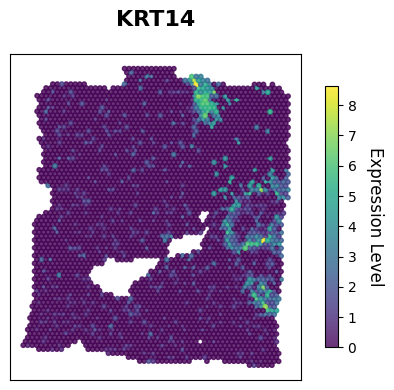

绘制基因 'S100A2' 的空间表达分布...
图像已保存到: ./results/HBC/Human_Breast_Cancer/genes/S100A2_spatial.png


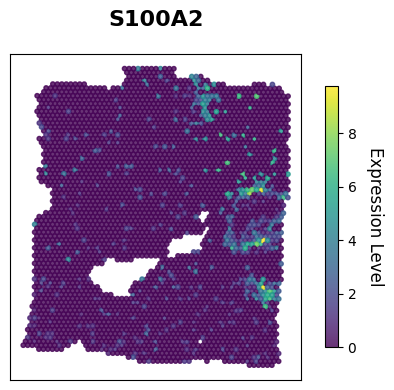

绘制基因 'PKP1' 的空间表达分布...
图像已保存到: ./results/HBC/Human_Breast_Cancer/genes/PKP1_spatial.png


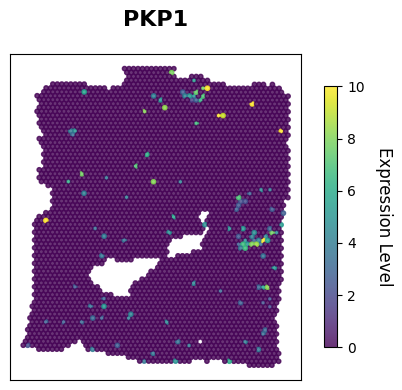

绘制基因 'MMP7' 的空间表达分布...
图像已保存到: ./results/HBC/Human_Breast_Cancer/genes/MMP7_spatial.png


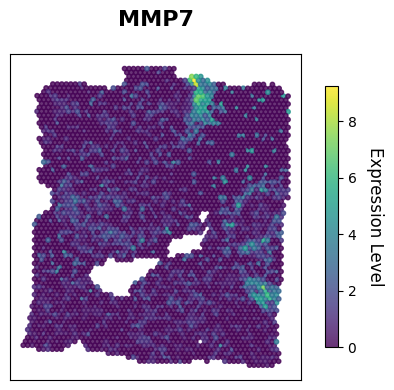

In [6]:
from package.utils import plot_spatial_gene_expression
marker_genes=[ 'KRT14', 'S100A2', 'PKP1', 'MMP7']
for i in marker_genes:#top_genes['names']
    plot_spatial_gene_expression(adata,i,spot_size=10,save_path=f'./results/HBC/Human_Breast_Cancer/genes/{i}_spatial.png',platform='')

绘制小提琴图: ['KRT14'] 在 6 vs 其他聚类


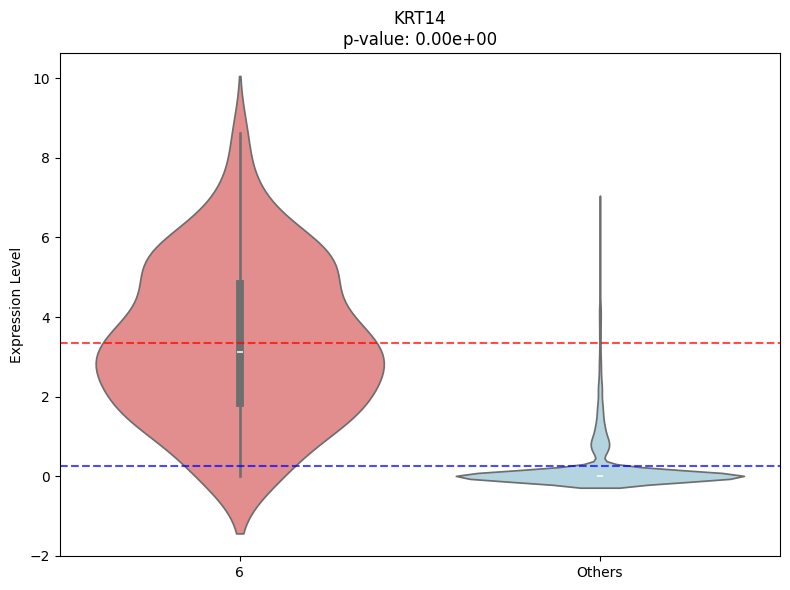

绘制小提琴图: ['S100A2'] 在 6 vs 其他聚类


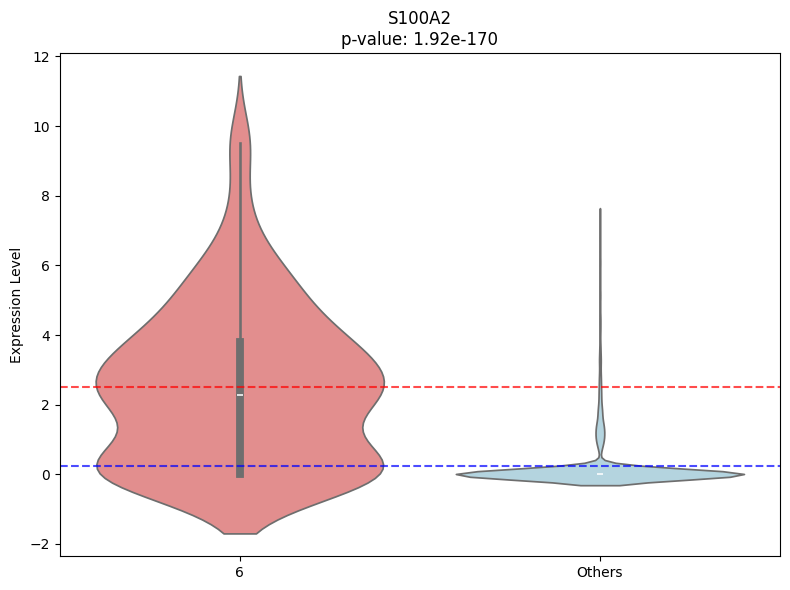

绘制小提琴图: ['PKP1'] 在 6 vs 其他聚类


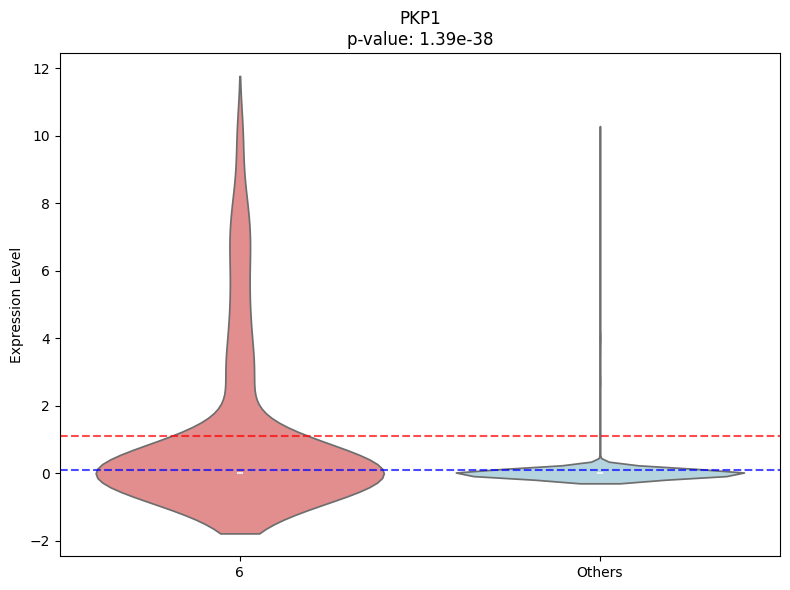

绘制小提琴图: ['MMP7'] 在 6 vs 其他聚类


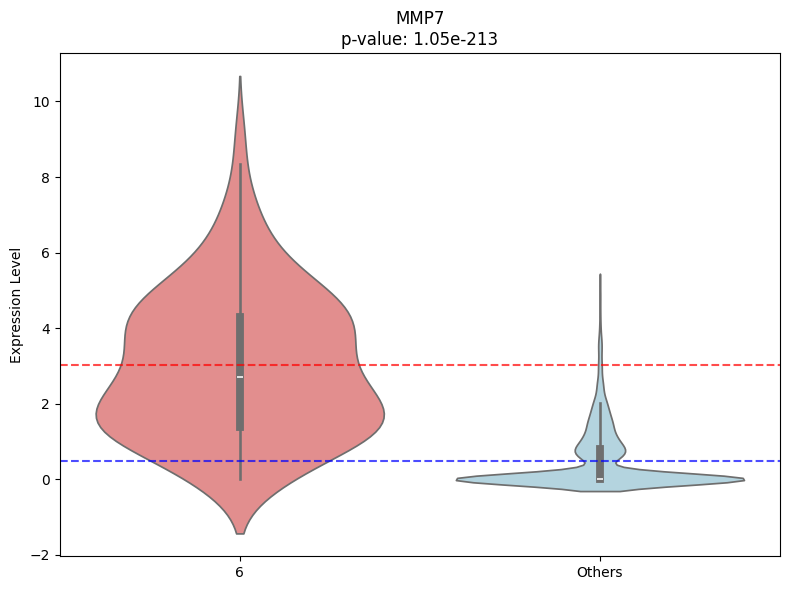

In [7]:
from package.utils import violin_plot_comparison

for i in marker_genes:
    violin_plot_comparison(adata,i,target_cluster='6',cluster_key='domain',save_path=f'./results/HBC/Human_Breast_Cancer/genes/{i}_violin_6.png')

开始运行GO分析并合并结果...
输入基因数量: 370
背景基因数量: 3000

--- 正在分析 GO Biological_Process ---
GO Biological_Process: 找到 2134 个显著条目，已选取前 10 个。

--- 正在分析 GO Molecular_Function ---
GO Molecular_Function: 找到 345 个显著条目，已选取前 10 个。

--- 正在分析 GO Cellular_Component ---
GO Cellular_Component: 找到 194 个显著条目，已选取前 10 个。

合并结果图已保存到: ./results/HBC/Human_Breast_Cancer/GO/6/Combined_GO_Enrichment.png


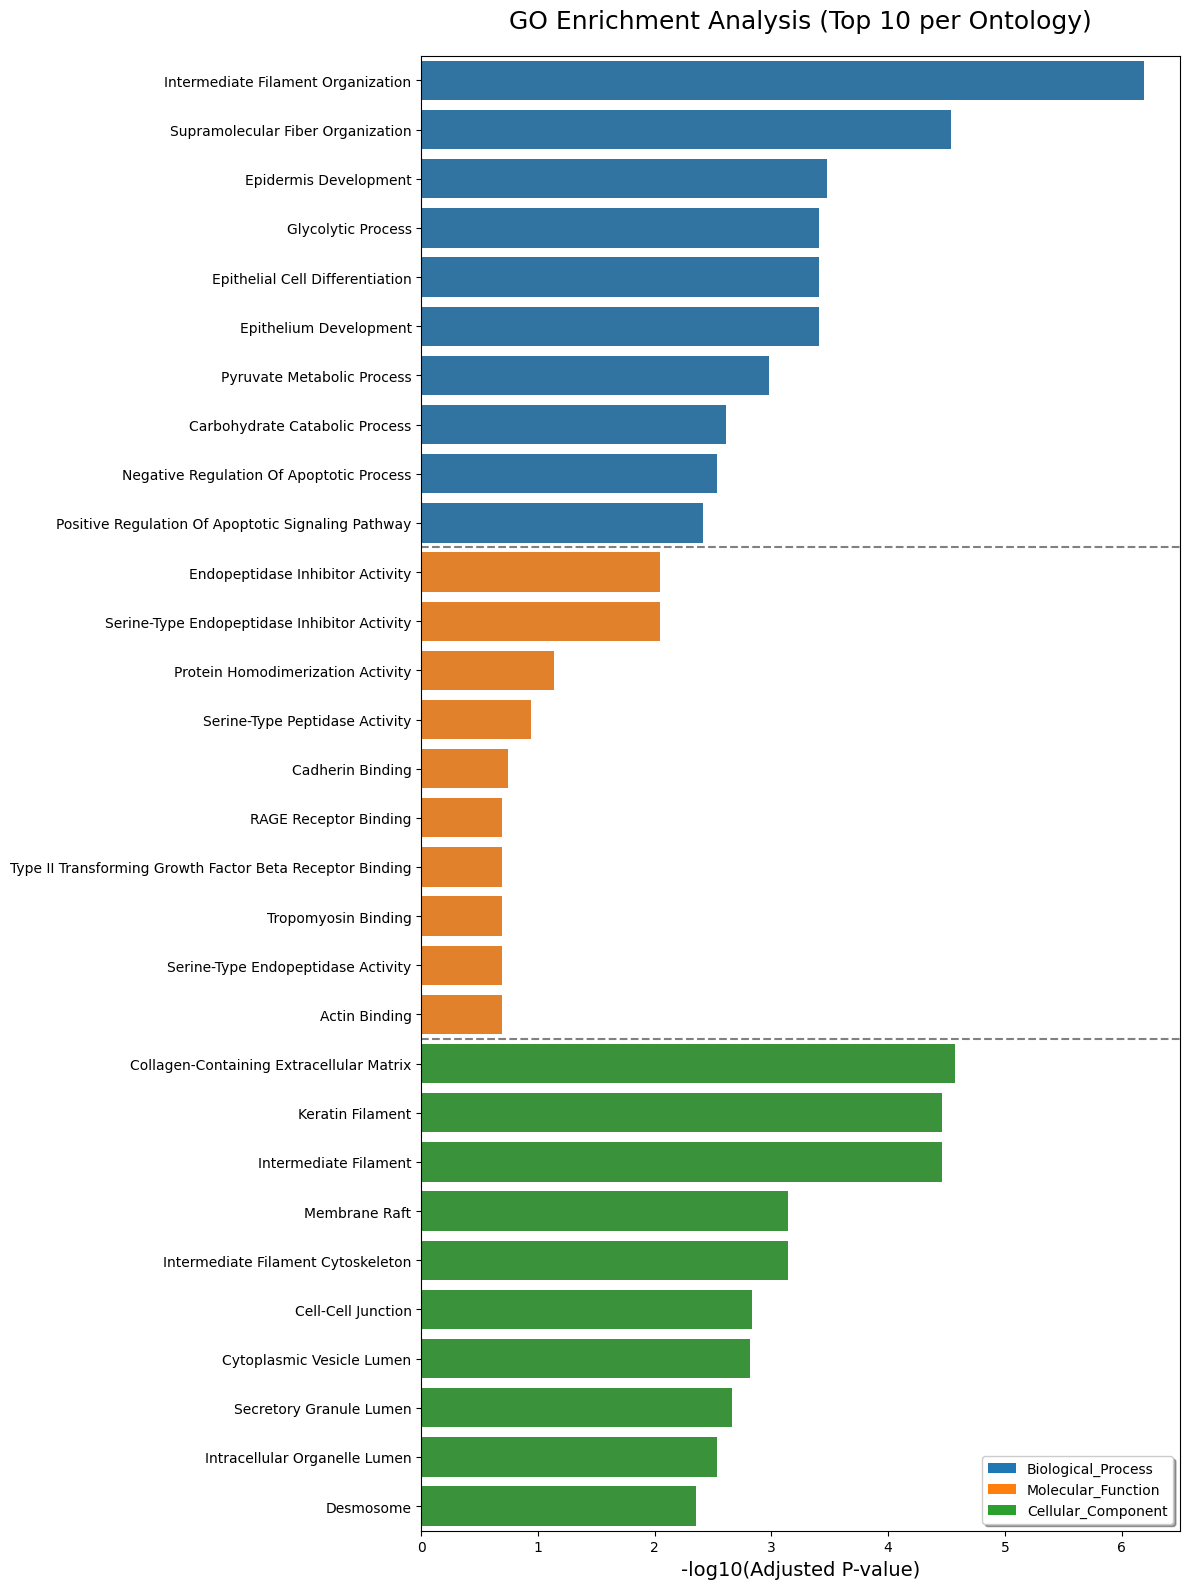

合并结果表已保存到: ./results/HBC/Human_Breast_Cancer/GO/6/Combined_GO_Results.csv


In [16]:
from package.utils import go_analysis

up_genes=result[result['significant'] & (result['logfoldchanges'] > 0)]['names']
down_genes=result[result['significant'] & (result['logfoldchanges'] < 0)]['names']
combined_results=go_analysis(up_genes,adata.var_names,outdir='./results/HBC/Human_Breast_Cancer/GO/6')

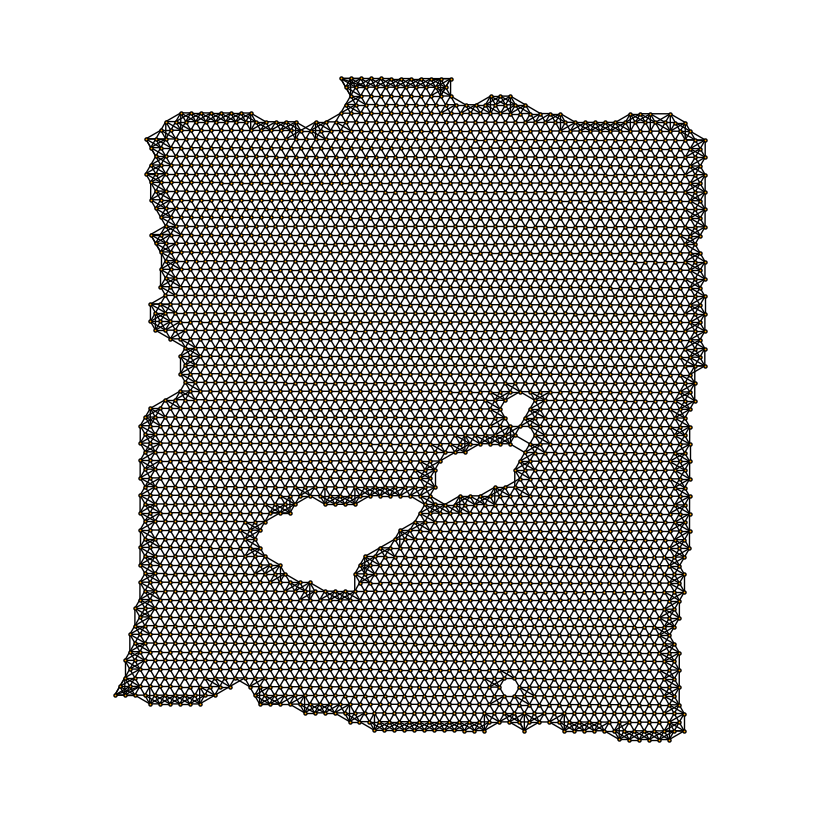

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

A = adata.obsm['graph_neigh_coor']# 邻接矩阵
pos = adata.obsm['spatial']# 每行对应节点的真实坐标
pos[:,1]=-1*pos[:,1]
# 2. 建图
G = nx.from_numpy_array(A)             # 无向图；有向加 create_using=nx.DiGraph

# 3. 把坐标转成 NetworkX 要的 dict 格式
pos_dict = {i: pos[i] for i in range(len(pos))}

# 4. 画图
plt.figure(figsize=(8,8))
nx.draw(G, pos_dict,
        with_labels=False,
        node_color='orange',
        edgecolors='black',
        node_size=5,
        font_weight='bold')
plt.axis('equal')                      # 保持 x/y 比例一致
plt.savefig('./results/HBC/Human_Breast_Cancer/graph_neigh_coor.png')
plt.show()